英文原版：https://github.com/langchain-ai/langchain-academy/tree/main

译者：Bryce Wang, brycewang2018@gmail.com

说明：此 notebook 不存在于原英文课程，为译者新加，用来复习本模块。

In [3]:
## Setup
## Set OpenAI API Key
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [4]:
## Set Langchain API Key
_set_env("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

# 1.1 Simple Graph

![Screenshot 2024-08-20 at 3.11.22 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png)

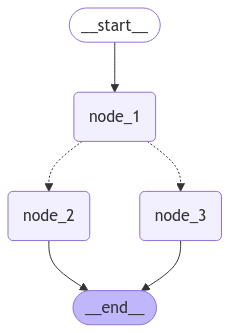

---Node 1---
state['graph_state'] = Hi, this is Lance.
---Node 3---
state['graph_state'] = Hi, this is Lance. I am


{'graph_state': 'Hi, this is Lance. I am sad!'}

In [1]:
## 1.1 Simple Graph

## 定义 state ##############################################################
## The State schema serves as the input schema for all Nodes and Edges in the graph 
from typing_extensions import TypedDict

## 定义了一个名为 State 的类型
## 这个类型继承了 TypedDict，声明 State 的实例是一个字典
## 字典中必须包含一个键名为 graph_state，其值的类型必须是 str（TypeDict 的核心作用）
class State(TypedDict):
    graph_state: str  ## 对于 graph_state 这个键，其值必须是 str 类型


## 这里的 State 并不是一个普通的类，它本质上是一个字典模板，实例化后仍然是一个普通的字典
## 作为类型检查工具（再比如 mypy），会确保字典的键和值符合定义
## 没有普通类的方法或动态行为，只是数据结构


## 定义了 3 个节点（函数） ######################################################
## 每个节点都接受一个 State 类型的参数，返回一个 State 类型的结果
def node_1(state):
    print("---Node 1---")
    print(f"state['graph_state'] = {state['graph_state']}")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    print(f"state['graph_state'] = {state['graph_state']}")
    return {"graph_state": state['graph_state'] +" happy!"}


def node_3(state):
    print("---Node 3---")
    print(f"state['graph_state'] = {state['graph_state']}")
    return {"graph_state": state['graph_state'] +" sad!"}


## 定义了 2 条边 ##############################################################
# 每条边都接受一个 State 类型的参数，返回一个 State 类型的结果
import random
## Literal 的字面意思是“字面值”。这是因为它允许你指定一个变量、参数或函数返回值的类型
## 为某些具体的值（字面值），而不是一个通用的类型
from typing import Literal

## Literal["node_2", "node_3"] 限定了函数 decide_mood 的返回值，只能是 "node_2" 或 "node_3"
def decide_mood(state) -> Literal["node_2", "node_3"]:  
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

## 定义了一个简单的图 ############################################################
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## 运行图 ############################################################
graph.invoke({"graph_state" : "Hi, this is Lance."})

## 案例结束 ###########################################################  

# 1.2 Chain

## 回顾

在上一个 ipynb 中，我们创建了一个包含多个节点、普通边和条件边的一个简单图。

## Goals

现在，让我们创建一个简单的 chain，基于下面的 4 个概念 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* 用 [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) 来当成 graph state（字典）
* 用 [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) 来建立节点（节点=基于大模型的函数）
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) - 为我们的大模型创建工具（工具=函数）
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) - 在图的节点中执行工具

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


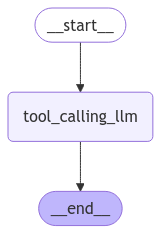

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?
================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_UJVl3uDWJot9nUP4NxIkMyH8)
 Call ID: call_UJVl3uDWJot9nUP4NxIkMyH8
  Args:
    a: 2
    b: 3


In [6]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

## 虚构一些人类用户和大模型 AI 的聊天记录
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

## 调用 OpenAI 的模型，用来构建 agent
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

## 定义一个工具函数 
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b
## 绑定函数到 llm 对象
llm_with_tools = llm.bind_tools([multiply])


## 基于 messages 定义 state
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

##  AnyMessage 是用来表示消息的泛型类型。这是一种类型注解，表示 messages 列表中的元素可以是任何消息类型，
## 例如 HumanMessage, AIMessage, SystemMessage 或 ToolMessage 等
class MessagesState(TypedDict): # 之前我们定义的叫 State; LangGraph 其实自带有 MessageState，下面会正式介绍
    messages: list[AnyMessage]

## MessagesState  
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

## Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
from typing import Annotated
from langgraph.graph.message import add_messages
add_messages(initial_messages , new_message)

## 创建图  ############################################################
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState) 
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## 运行图 ############################################################
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

## 后面的 notebook，会介绍如何执行工具函数，并返回结果
# END 

# 1.3 Router

## 回顾

我们构建了一个使用 `messages` 作为状态的图，并绑定了工具的聊天模型。

我们发现该图可以：

- 返回一个工具调用
- 返回一个自然语言响应

## Goals

我们可以将其视为一个路由器，其中聊天模型根据用户输入在直接响应和工具调用之间进行路由。

这是一个代理的简单示例，其中 LLM 控制流程的方向，要么调用工具，要么直接响应。

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)


让我们扩展这个图，使其可以处理这两种输出！

为此，我们可以使用两个想法：

- 添加一个节点，用于调用我们的工具。

- 添加一个条件边，根据聊天模型的输出，将流程路由到`工具调用`节点，或者如果未执行工具调用，则直接`结束`。

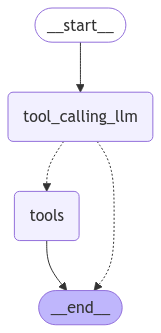

================================ Human Message =================================

Hello world.
================================== Ai Message ==================================

Hello! How can I assist you today?

*回答问题：What is 2 multiply by 3?
================================ Human Message =================================

What is 2 multiply by 3?.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_FMu8wLY8K0ADc0dReMvCXwLm)
 Call ID: call_FMu8wLY8K0ADc0dReMvCXwLm
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [11]:
## 定义并绑定工具 multiply 函数
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])


## 创建图
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

## MessagesState is defined with a single messages key 
## which is a list of AnyMessage objects and uses the add_messages reducer. 
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm) ## 工具调用节点
builder.add_node("tools", ToolNode([multiply])) # 工具节点
builder.add_edge(START, "tool_calling_llm") # 开始节点 --> 工具调用节点
builder.add_conditional_edges( # 工具调用节点 -条件边-> 工具节点
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


## 运行图 ############################################################
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello world.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

## 提出一个乘法相关的题目 ################################################ 
print()
print("*回答问题：What is 2 multiply by 3?")
messages = [HumanMessage(content="What is 2 multiply by 3?.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

# 1.4 Agent

# 1.4 Agent

## 回顾

我们构建了一个路由器 router。

- 我们的聊天模型将根据用户输入决定是否进行工具调用。
- 我们使用条件边将流程路由到调用工具的节点，或者直接结束。

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## Goals 目标 

现在，我们可以将其扩展为一个通用的代理架构。

在上面的路由器中，我们调用了模型，并在它选择调用工具时，将一个 `ToolMessage` 返回给用户。

但是，如果我们将这个 ToolMessage *传回模型*呢？

我们可以让模型执行以下操作之一：

- 调用另一个工具
- 直接响应

这正是 [ReAct](https://react-lm.github.io/) 通用代理架构背后的直觉。

- `act`：让模型调用特定工具
- `observe`：将工具输出结果，传回给大模型
- `reason`：下图红色箭头，让模型评估`工具的输出`，以决定下一步的操作，例如，调用另一个工具或直接回答问题。

这种通用架构[general purpose architecture](https://blog.langchain.dev/planning-for-agents/) 可以应用于多种类型的工具。

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

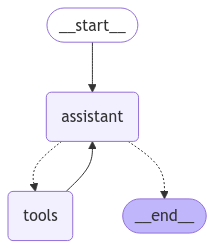

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_GSIdHnVSkmqYrGWtHNy7n9mY)
 Call ID: call_GSIdHnVSkmqYrGWtHNy7n9mY
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_YHrzI38WnigIP3oYZjpq0CqW)
 Call ID: call_YHrzI38WnigIP3oYZjpq0CqW
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_PeLnKYtF36fPdNEUrAwVuWPr)
 Call ID: call_PeLnKYtF36fPdNEUrAwVuWPr
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

In [12]:
## 定义多个工具，让大模型进行调用
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")

# 在此 ipynb 文件中，我们将`并行工具调用`设置为 False，因为数学通常是按顺序完成的。这次我们有三个可以处理数学的工具。
# OpenAI 模型默认使用并行工具调用以提高效率，请参阅相关文档。
# 尝试调试一下，看看模型在处理数学方程时的行为如何！

## 绑定工具到 llm 对象
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)


## 让我们创建我们的 LLM 和提示词模板，并通过一个期望的整体代理行为提示，来进行初始化。 ######################## 
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

## 创建图 ############################################################
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant) ## 大模型助手节点，决定是否需要调用工具
builder.add_node("tools", ToolNode(tools)) ## 工具节点，运行函数工具

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant") # 普通边
builder.add_conditional_edges( # 条件边
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant") # 这里加了一条返回的边，形成闭环。
react_graph = builder.compile()

## 显示图的架构
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## 运行图 ############################################################
## 运行图
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

## 打印全部结果
for m in messages['messages']:
    m.pretty_print()

# 1.5 Agent with Memory

# 1.5 Agent memory

## 回顾

之前，我们构建了一个可以执行以下操作的代理：

- `act`：让模型调用特定工具
- `observe`：将工具输出传回模型
- `reason`：让模型根据工具输出进行推理，决定下一步操作（例如，调用另一个工具或直接响应）。


![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Goals

现在，我们将通过引入记忆来扩展我们的代理。

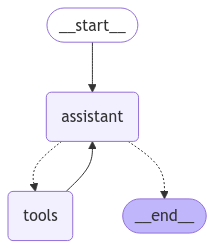

Without Memory:
================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_aCmlbhdJMpRIOd7gyvdnuGc2)
 Call ID: call_aCmlbhdJMpRIOd7gyvdnuGc2
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.



*With Memory
================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_4kPBWR9UTlmgiAqnDhI5j7t4)
 Call ID: call_4kPBWR9UTlmgiAqnDhI5j7t4
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum

In [15]:
## 定义了 3 个工具函数
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools) # 绑定工具函数


## 定义了一个 assistant agent ############################################################
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState): # state 
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


## 创建图 ############################################################
## 创建一个图
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant") ## 从 tools 节点返回 assistant 节点，形成闭环
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## 运行图 wo Memory ############################################################
## 运行图
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
print("Without Memory:")
for m in messages['messages']:
    m.pretty_print()

print()
print()

## 运行图 with Memory ############################################################
## 引入 检查点工具 MemorySaver
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

## 指定一个 thread
config = {"configurable": {"thread_id": "1"}}

## 指定人类的问题输入
messages = [HumanMessage(content="Add 3 and 4.")]

## 运行图
print()
print("*With Memory")
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

## With Memory  ###############################################################
## 通过 config 和 thread_id 指定了一个线程，这样就可以使用之前的对话历史  
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)

print()
print("*With Memory +  Multiply that by 2")
for m in messages['messages']:
    m.pretty_print()

## END 

In [ ]:
# END 